# 01. Load packages

<img src=https://miro.medium.com/max/910/1*nZIFUJv5zwuVTh1tHaYFkg.png width="700">
<br>
<center><b>Fig. The difference of the Bagging and Boosting</b></center>

In [2]:
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import StratifiedKFold as SKF
from tqdm import tqdm

from matplotlib import pyplot as pl
import seaborn as sbn
from sklearn.metrics import confusion_matrix, f1_score

import os
from collections import Counter
import random

from tqdm import tqdm

import pandas as pds
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sbn

df = pds.read_csv(os.path.join('data','winequality-red.csv'), delimiter=';')
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [3]:
df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [4]:
df.quality = df.quality.apply(lambda x: x if x != 3 else 4)
df.quality.value_counts()

5    681
6    638
7    199
4     63
8     18
Name: quality, dtype: int64

In [5]:
df.quality -= 4
df.quality.value_counts()

1    681
2    638
3    199
0     63
4     18
Name: quality, dtype: int64

In [6]:
cfg = dict(
    seed = 2022,
)

skf = SKF(shuffle = True, random_state = cfg['seed'])
for train_idx, valid_idx in skf.split(df, df.quality):
    train_df = df.iloc[train_idx]
    valid_df = df.iloc[valid_idx]
    break

0     13
1    137
2    127
3     40
4      3
Name: quality, dtype: int64


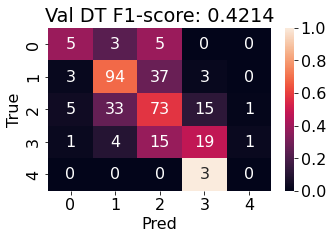

In [7]:
dt = DT(random_state=cfg['seed'])

X = train_df.drop(columns = 'quality').values
y = train_df.quality.values

dt.fit(X, y)
dt_logits = dt.predict_proba(valid_df.drop(columns = 'quality').values).argmax(1)

print(valid_df.quality.value_counts().sort_index())
dt_cm = confusion_matrix(
    valid_df.quality.values, 
    dt_logits,
)
dt_norm_cm = dt_cm / dt_cm.sum(1, keepdims = True)

dt_f1 = f1_score(
    valid_df.quality.values, 
    dt_logits,
    average = 'macro'
)

plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize = (5,3))

sbn.heatmap(dt_norm_cm, annot=dt_cm, ax = ax, fmt = '.4g')
ax.set_ylabel('True') ; ax.set_xlabel('Pred')
ax.set_title('Val DT F1-score: {:.4g}'.format(dt_f1))
fig.show()

# 02. Bagging


<figure>
    <img 
       src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbLHXE3%2Fbtqw7cWPjSb%2FxKoaC8GrwfFbAN2CMraSw0%2Fimg.png" 
       width="700">
</figure>
<br>
<center><b>Fig. Illustrate for the bagging</b></center>

### The key of the bagging

    1. Reproducable randomized SEED & ML model
    
    2. Uniformly random selected columns and rows of the pds.DataFrame

In [8]:
df.shape

(1599, 12)

In [9]:
def set_next_seed(seed):
    np.random.seed(seed)
    return np.random.randint(0, 100000, 1)[0]


def partition_df(df, bagging_ratio):
    n_rows, n_cols = df.shape

    target = df.quality
    X = df.drop(columns = 'quality')
    
    random_row_indexes = np.random.choice(X.index, int(n_rows * bagging_ratio))
    random_col_indexes = np.random.choice(X.columns, int(n_cols * bagging_ratio))

    return X.loc[random_row_indexes, random_col_indexes], df.quality[random_row_indexes], random_col_indexes


def make_learners(train_df, bagging_ratio, n_bagging_size, seed = 2002):
    seeds = []
    learners = []
    cols = []
    
    for n in tqdm(range(n_bagging_size)):

        seed = set_next_seed(seed)
        seeds.append(seed)
        
        sub_df, sub_target, sub_cols = partition_df(train_df, bagging_ratio)
        
        learner = DT(
            random_state=seed, 
        )
        learners.append(learner.fit(sub_df, sub_target))
        cols.append(sub_cols)
        
    return learners, cols

In [10]:
cfg = dict(
    bagging_ratio = .6,
    n_bagging_size = 300,
    seed = 2022,
)

In [11]:
learners, cols = make_learners(train_df, **cfg)

preds = [l.predict_proba(valid_df[c]) for c,l in zip(cols, learners)]
bag_logits = np.stack(preds, 1)
bag_logits.shape

100%|██████████| 300/300 [00:01<00:00, 223.85it/s]


(320, 300, 5)

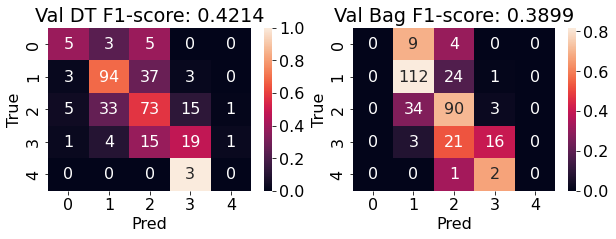

In [12]:

bag_cm = confusion_matrix(
    valid_df.quality, 
    bag_logits.sum(1).argmax(1),
)
bag_norm_cm = bag_cm / bag_cm.sum(1, keepdims = True)

bag_f1 = f1_score(
    valid_df.quality, 
    bag_logits.sum(1).argmax(1),
    average = 'macro'
)


plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(1, 2, figsize = (10,3))

sbn.heatmap(dt_norm_cm, annot=dt_cm, ax = ax[0], fmt = '.4g')
ax[0].set_ylabel('True') ; ax[0].set_xlabel('Pred')
ax[0].set_title('Val DT F1-score: {:.4g}'.format(dt_f1))

sbn.heatmap(bag_norm_cm, annot=bag_cm, ax = ax[1], fmt = '.4g')
ax[1].set_ylabel('True') ; ax[1].set_xlabel('Pred')
ax[1].set_title('Val Bag F1-score: {:.4g}'.format(bag_f1))


fig.show()

# 03. Adaboost


<br><br>
<figure>
    <img 
       src="https://vitalflux.com/wp-content/uploads/2020/09/Screenshot-2020-09-09-at-8.17.33-AM.png" 
       width="700">
</figure>
<br>
<center><b>Fig. Understanding Boosting Classification (Source: Python Machine Learning 3rd edition by Dr. Sebastian R)</b></center>

<img src=https://i.stack.imgur.com/mQ9Np.png width="700">
<br>
<center><b>Fig. Adaboost algorithm</b></center>


### The key of the AdaBoost

    1. Sequatial base learner
    
    2. Adjustable sampling weight for training base learner

Text(0.5, 0, 'Error')

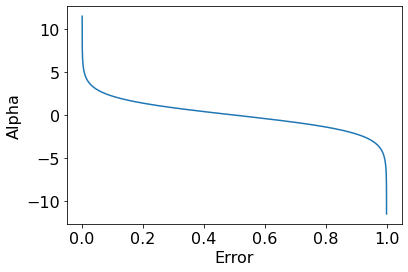

In [13]:
er = np.arange(1e-5, 1, 1e-5)
plt.plot(
    er, np.log( ( 1 - er ) / er ) 
)
plt.ylabel('Alpha')
plt.xlabel('Error')

According to above error vs alpha figure, bigger error makes to small update alpha in the exponential scale, and viceversa.

And, it may differ to 'SAMME.R' algorithm, as "Multi-class AdaBoost", J. Zhu, H. Zou, S. Rosset, T. Hastie, 2009.

---------------
Algorithm 1. AdaBoost 

   1. Initialize sample weights $w_i = \frac{1}{N}$, with $X \in \mathbb{R}^{N \times K}$.

   2. Repeat the loop $t$ until $T$ times using the stump of AdaBoost.
   
       2-1. Recieve Variables, Targets, and Sample_weights by Variables.
       
       2-2. Make the number $t$ tree $F_t$ that should be weaker than full tree.
       
       2-3. Training and evaluating the tree's performance (In this step, we check the relationship between targets and predictions).
       
       2-4. Compute error followed as, 
       $$err_t = \frac{\sum^N_{i=1}w_i\mathbb{1}(y_i \neq F_t(x_i))}{\sum^N_{i=1}w_i}.$$
       
       2-5. Compute alpha as, $\alpha_t = \log{\{(1-err_t)/err_t\}}$
       
       2-6. Set to new sample_weights that is re-normalized.
       $$w^n_i = w_i \cdot e^{ [ \alpha_t \cdot \mathbb{1}(y_i \neq F_t(x_i) ] }, \mathrm{for}\ i = 1, 2, 3, \cdots, N$$
       $$w_i = \frac{w^n_i}{\sum w^n_i}$$
       
   3. For prediction steps, we perform to predict with base learner and their alpha.

In [14]:
class adboost:
    def __init__(self, cfg):
        self._cfg = cfg
        
    
    
    def __step__(self, X, y, seed, sample_weight):
        dt = DT(
            max_depth = self._cfg['max_depth'], 
            random_state = seed,
            max_leaf_nodes = self._cfg['max_leaf_nodes']
        )
        
        dt.fit(X,y,sample_weight)
        
        y_hat = dt.predict(X)
        
        error = sum(sample_weight*(y != y_hat)) / sum(sample_weight) # sum(sample_weight*(len(y)))
        alpha = np.log((1-error)/error) 
        sample_weight = sample_weight * np.exp(alpha*(y != y_hat)) 
        sample_weight /= sample_weight.sum()
        

        seed = set_next_seed(seed)
        
        return dt, seed, alpha, sample_weight, error
            
            
    
    
    def __call__(self, X, y):
        sample_weight = np.ones(len(X)) / len(X)
        seed = self._cfg['seed']
        self.logger = dict(
            alpha = [],
            base = [],
            seed = [],
            error = [],
        )
        
        for _ in tqdm(range(self._cfg['n_boosting'])):
            dt, seed, alpha, sample_weight, error = self.__step__(X,y,seed,sample_weight)
            
            self.logger['base'].append(dt)
            self.logger['seed'].append(seed)
            self.logger['alpha'].append(alpha)
            self.logger['error'].append(error)
            
            
    def predict(self, X):
        logits = []
        for a,b,s,e in zip(*self.logger.values()):
            logits.append((a*b.predict_proba(X)))
            '''?'''
            
        return logits

In [15]:
X = train_df.drop(columns = 'quality').values
y = train_df.quality.values
sample_weight = np.ones(len(train_df)) / len(train_df)

In [16]:
cfg = dict(
    max_depth = 8,
    max_leaf_nodes = None,
    seed = cfg['seed'],
    n_boosting = 100,
)

model = adboost(cfg)

In [17]:
X = train_df.drop(columns = 'quality').values
y = train_df.quality.values


model(X, y)

100%|██████████| 100/100 [00:00<00:00, 171.02it/s]


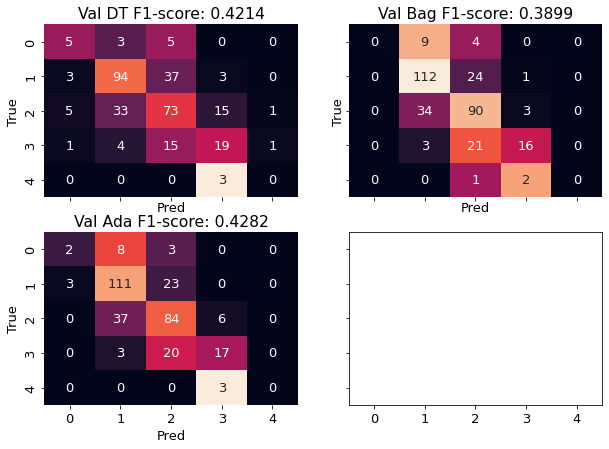

In [18]:
adb_logits = np.array(model.predict(valid_df.drop(columns = 'quality').values)).sum(0).argmax(1)


adb_cm = confusion_matrix(
    valid_df.quality, 
    adb_logits,
)
adb_norm_cm = adb_cm / adb_cm.sum(1, keepdims = True)

adb_f1 = f1_score(
    valid_df.quality, 
    adb_logits,
    average = 'macro'
)




plt.rcParams['font.size'] = 13
fig, ax = plt.subplots(2, 2, figsize = (10,7), sharex = True, sharey = True)

sbn.heatmap(dt_norm_cm, annot=dt_cm, ax = ax[0][0], fmt = '.4g', cbar = False)
ax[0][0].set_ylabel('True') ; ax[0][0].set_xlabel('Pred')
ax[0][0].set_title('Val DT F1-score: {:.4g}'.format(dt_f1))

sbn.heatmap(bag_norm_cm, annot=bag_cm, ax = ax[0][1], fmt = '.4g', cbar = False)
ax[0][1].set_ylabel('True') ; ax[0][1].set_xlabel('Pred')
ax[0][1].set_title('Val Bag F1-score: {:.4g}'.format(bag_f1))

sbn.heatmap(adb_norm_cm, annot=adb_cm, ax = ax[1][0], fmt = '.4g', cbar = False)
ax[1][0].set_ylabel('True') ; ax[1][0].set_xlabel('Pred')
ax[1][0].set_title('Val Ada F1-score: {:.4g}'.format(adb_f1))

fig.show()

# 04. Gradient Boosting


<figure>
    <img 
       src="https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-from-2021-03-25-13-16-38.png" 
       width="700">
</figure>
<br>
<center><b>Fig. Understanding Gradient Boosting Regression</b></center>


### The key of the boosting

    1. Sequatial base learner for predicting to the residual from base line.
    
    2. For the generalization, we can apply the bagging methods in the boosing sequence.

- GB는 회귀를 위해 나옴
- 에러가 다음 타겟

In [19]:
from collections import Counter
from sklearn.tree import DecisionTreeRegressor as DTR


cfg = dict(
    max_depth = 3,
    max_leaf_nodes = 6,
    seed = cfg['seed'],
    n_boosting = 600,
    bootstrap_ratio = .4
)



In [20]:
class gradient_boosting:
    def __init__(self, cfg):
        self._cfg = cfg
        
        
    
    def partition_df(self, X):
        n_rows, n_cols = X.shape
        random_col_indexes = np.random.choice(X.columns, int(n_cols * self._cfg['bootstrap_ratio']))
        return X[random_col_indexes], random_col_indexes

        
    @staticmethod
    def mse_fn(res):
        return ( res ** 2 ).mean()
        
        
    def __call__(self, X, y):
        self.base_score = y.mean()
        residual = (y- self.base_score).values
        self._logger = dict(
                base_learner = [],
                cols = [],
                scores = [],
                residual_pred =[]
                )

        seed = self._cfg['seed']
        np.random.seed(seed)
        
        for n in tqdm(range(self._cfg['n_boosting'])):
            seed = set_next_seed(seed)
            base_learner, sub_cols, residual, residual_predict = self.step(X, residual, seed)
            
            self._logger['base_learner'].append(base_learner)
            self._logger['cols'].append(sub_cols)
            self._logger['scores'].append(gradient_boosting.mse_fn(residual-residual_predict))
            self._logger['residual_pred'].append(residual_predict)
            
            
    def step(self, X, residual, seed):
        sub_df, sub_cols = self.partition_df(X)

        base_learner = DTR(
            max_depth=self._cfg['max_depth'],
            random_state=seed,
            max_leaf_nodes=self._cfg['max_leaf_nodes'],
        )

        base_learner.fit(sub_df, residual)
        residual_predict = base_learner.predict(sub_df)
        residual -= residual_predict
        
        return base_learner, sub_cols, residual, residual_predict
    
    
    def predict(self, X):
        preds = []
        for col, base in zip(self._logger['cols'], self._logger['base_learner']):
            preds.append(base.predict(X[col]))
            
        gb_logits = (np.array(preds).sum(0) + self.base_score).round().astype(int)
        gb_logits[gb_logits>4] = 4 ; gb_logits[gb_logits<0] = 0 # regression 문제이기 때문에 bound과정
         
        return gb_logits

100%|██████████| 600/600 [00:01<00:00, 388.58it/s]


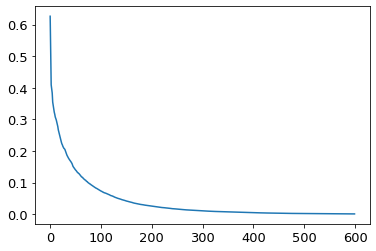

In [21]:
train_X = train_df.drop(columns = ['quality'])
train_y = train_df.quality


model = gradient_boosting(cfg)
model(train_X, train_y)

gb_logits = model.predict(valid_df.drop(columns = ['quality']))
plt.plot(model._logger['scores'])

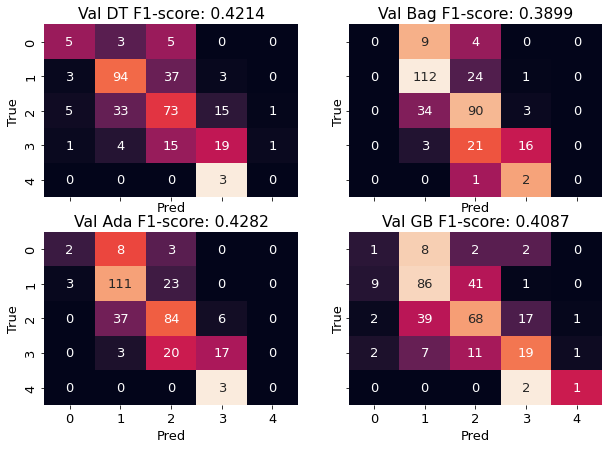

In [22]:
gb_cm = confusion_matrix(
    valid_df.quality, 
    gb_logits,
)
gb_norm_cm = gb_cm / gb_cm.sum(1, keepdims = True)

gb_f1 = f1_score(
    valid_df.quality, 
    gb_logits,
    average = 'macro'
)

plt.rcParams['font.size'] = 13
fig, ax = plt.subplots(2, 2, figsize = (10,7), sharex = True, sharey = True)

sbn.heatmap(dt_norm_cm, annot=dt_cm, ax = ax[0][0], fmt = '.4g', cbar = False)
ax[0][0].set_ylabel('True') ; ax[0][0].set_xlabel('Pred')
ax[0][0].set_title('Val DT F1-score: {:.4g}'.format(dt_f1))

sbn.heatmap(bag_norm_cm, annot=bag_cm, ax = ax[0][1], fmt = '.4g', cbar = False)
ax[0][1].set_ylabel('True') ; ax[0][1].set_xlabel('Pred')
ax[0][1].set_title('Val Bag F1-score: {:.4g}'.format(bag_f1))

sbn.heatmap(adb_norm_cm, annot=adb_cm, ax = ax[1][0], fmt = '.4g', cbar = False)
ax[1][0].set_ylabel('True') ; ax[1][0].set_xlabel('Pred')
ax[1][0].set_title('Val Ada F1-score: {:.4g}'.format(adb_f1))

sbn.heatmap(gb_norm_cm, annot=gb_cm, ax = ax[1][1], fmt = '.4g', cbar = False)
ax[1][1].set_ylabel('True') ; ax[1][1].set_xlabel('Pred')
ax[1][1].set_title('Val GB F1-score: {:.4g}'.format(gb_f1))

fig.show()

Using matplotlib backend: <object object at 0x7f5446ab5180>


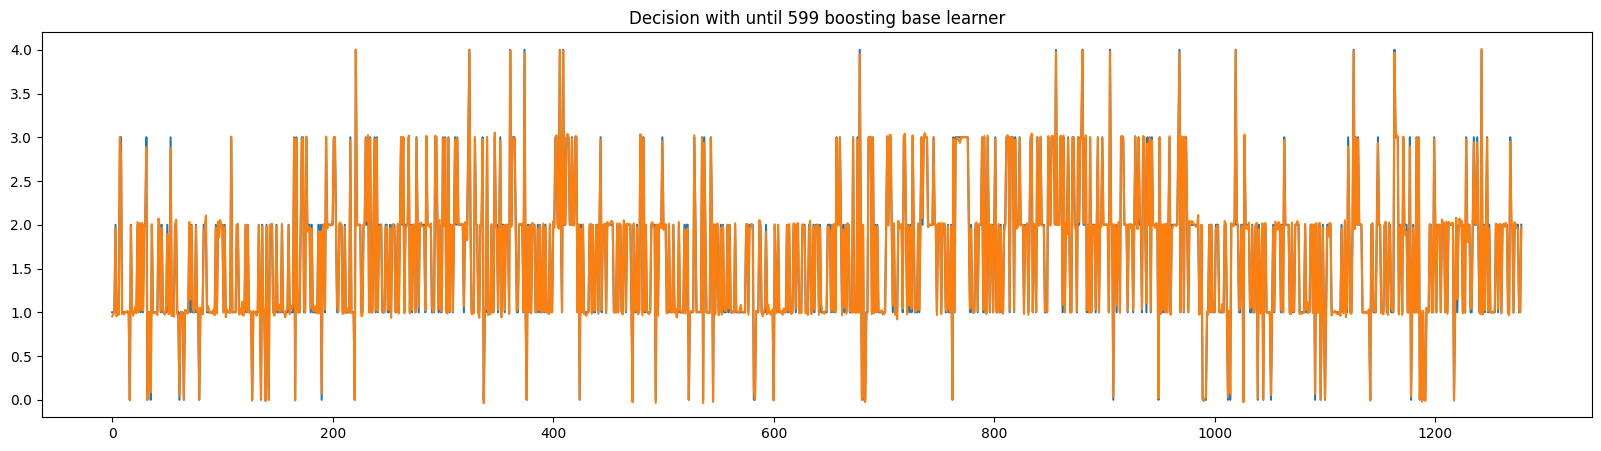

In [23]:
# import matplotlib
import time
from IPython import display
%matplotlib
# plt.ion()
    
scores = model.base_score.copy()
fig, ax = plt.subplots(figsize = (20,5))

line1 = ax.plot(range(len(train_df)), train_df.quality)
line2 = ax.plot(scores)

handles = display.display(fig.canvas.figure, display_id = True)

for n,rp in enumerate(model._logger['residual_pred']):
    
    
    scores += rp
    
    line2[0].set_xdata(range(len(train_df)))
    line2[0].set_ydata(scores)
    ax.set_title(f'Decision with until {n} boosting base learner')
    
    display.update_display(fig.canvas.figure, display_id = handles.display_id)
    time.sleep(.005)
    
# #     plt.close()
    